We now consider $a = 0.9 \neq 0$ in the Kerr metric with $E = 0.95$ and $L_z = 3$. The effective potential gives the allowed range of $r_0$ for which the initial conditions $\theta = \pi/2$, $r = r_0$ and $\frac{dr}{d\tau} = 0$ lead to bounded motion. This is approximately $4.6$ to $14.3$.

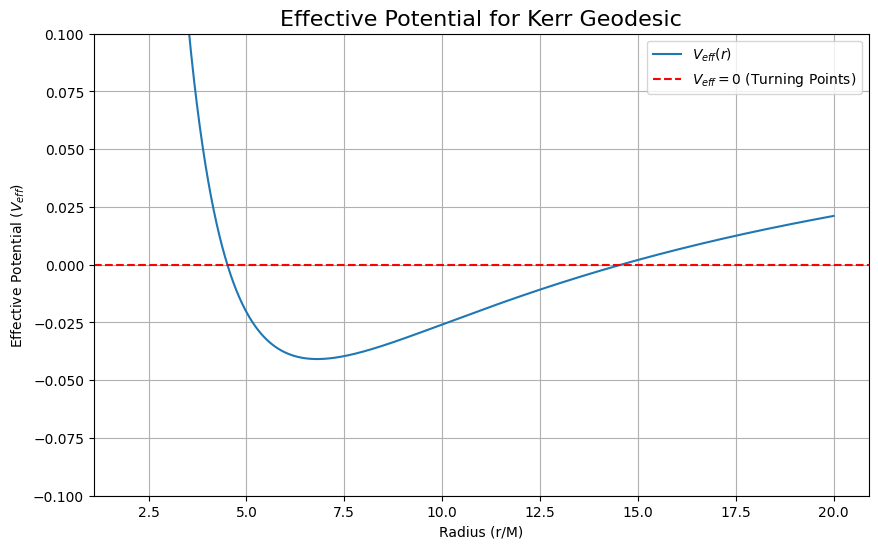

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def plot_kerr_effective_potential():
    '''
    Calculates and plots the effective potential for the given Kerr parameters
    to find the allowed range of motion for bound orbits.
    '''
    # Parameters
    a = 0.9
    E = 0.95
    Lz = 3.0
    m = 1.0

    # Create a range of r values to test
    r = np.linspace(2, 20, 500)

    # Kerr metric components in the equatorial plane (theta = pi/2)
    # Sigma = r^2, sin(theta)=1
    g_tt = 1 - 2*m/r
    g_tphi = 2*a*m/r
    g_phiphi = -( (r**2 + a**2)**2 - a**2*(r**2 - 2*m*r + a**2) ) / r**2

    denominator = g_tphi**2 - g_tt * g_phiphi
    numerator = E**2 * g_phiphi + 2*E*Lz*g_tphi + Lz**2 * g_tt
    # Effective Potential (kappa = -1 for timelike geodesics)
    V_eff = 1 + numerator / denominator

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(r, V_eff, label='$V_{eff}(r)$')
    plt.axhline(0, color='r', linestyle='--', label='$V_{eff} = 0$ (Turning Points)')
    plt.title('Effective Potential for Kerr Geodesic', fontsize=16)
    plt.xlabel('Radius (r/M)')
    plt.ylabel('Effective Potential ($V_{eff}$)')
    plt.grid(True)
    plt.ylim(-0.1, 0.1) # Zoom in near the zero-axis
    plt.legend()
    plt.show()

plot_kerr_effective_potential()

In [40]:
import sympy
from sympy import symbols, sin, cos, Matrix, diff, simplify, init_printing
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def setup_numerical_kerr_functions(m_val, a_val):
    '''
    A compact function to perform symbolic setup and return numerical functions.
    '''
    t, r, th, ph, m, a = symbols('t r th ph m a')
    Sigma = r**2 + a**2*cos(th)**2
    Delta = r**2 - 2*m*r + a**2
    A = (r**2 + a**2)**2 - a**2*Delta*sin(th)**2
    g_ll = Matrix([
        [1 - 2*m*r/Sigma, 0, 0, 2*a*m*r*sin(th)**2/Sigma],
        [0, -Sigma/Delta, 0, 0],
        [0, 0, -Sigma, 0],
        [2*a*m*r*sin(th)**2/Sigma, 0, 0, -A/Sigma*sin(th)**2]
    ])

    # Substitute numerical values
    g_ll_num = g_ll.subs({m: m_val, a: a_val})

    # Lambdify g_ll
    g_funcs = np.empty((4, 4), dtype=object)
    for i in range(4):
        for j in range(4):
            expr = g_ll_num[i,j]
            g_funcs[i,j] = sympy.lambdify([r, th], expr, 'numpy') if expr != 0 else lambda r, th: 0

    # Calculate and Lambdify Gamma_ull
    g_uu_num = g_ll_num.inv()
    dg_matrices = [g_ll_num.diff(coord) for coord in [t, r, th, ph]]
    Gamma_funcs = np.empty((4, 4, 4), dtype=object)
    for i in range(4):
        for j in range(4):
            for k in range(4):
                raw_sum = sum(g_uu_num[i, m_idx] * (dg_matrices[k][j, m_idx] + dg_matrices[j][k, m_idx] - dg_matrices[m_idx][j, k]) for m_idx in range(4))
                expr = 0.5 * raw_sum
                Gamma_funcs[i, j, k] = sympy.lambdify([r, th], expr, 'numpy') if expr != 0 else lambda r, th: 0

    return g_funcs, Gamma_funcs

def kerr_geodesic_odes(tau, y, Gamma_funcs):
    '''
    The ODE system function.
    '''
    _, r_val, theta_val, _, u_t, u_r, u_theta, u_phi = y
    four_velocity = np.array([u_t, u_r, u_theta, u_phi])
    dydtau = np.zeros(8)
    dydtau[:4] = four_velocity
    for i in range(4):
        accel_sum = -sum(Gamma_funcs[i, j, k](r_val, theta_val) * four_velocity[j] * four_velocity[k] for j in range(4) for k in range(4))
        dydtau[i + 4] = accel_sum
    return dydtau

def integrate_geodesic(y0, tau_span, Gamma_funcs, events=None):
    '''
    The integrator function.
    '''
    ode_func = lambda tau, y: kerr_geodesic_odes(tau, y, Gamma_funcs)
    sol = solve_ivp(
        fun=ode_func, t_span=tau_span, y0=y0,
        method='DOP853', rtol=1e-8, atol=1e-8,
        events=events
    )
    return sol

In [41]:
def run_poincare_simulation_kerr(g_funcs, Gamma_funcs, E, Lz, a, r0_values):
    '''
    Generates the Poincaré map for the Kerr metric.
    '''
    poincare_points = []

    def equatorial_crossing(tau, y): return y[2] - np.pi / 2
    equatorial_crossing.direction = 1; equatorial_crossing.terminal = False

    for r0 in r0_values:
        theta0 = np.pi/2
        ur0 = 0

        # Evaluate metric components at the starting point
        g_tt0 = g_funcs[0, 0](r0, theta0); g_tphi0 = g_funcs[0, 3](r0, theta0)
        g_thth0 = g_funcs[2, 2](r0, theta0); g_phphi0 = g_funcs[3, 3](r0, theta0)

        det = g_tt0 * g_phphi0 - g_tphi0**2
        ut0 = (E * g_phphi0 + Lz * g_tphi0) / det
        uphi0 = (-Lz * g_tt0 - E * g_tphi0) / det

        V_eff_0 = -1 + (E**2*g_phphi0 + 2*E*Lz*g_tphi0 + Lz**2*g_tt0) / det
        utheta0_squared = -V_eff_0 / g_thth0

        if utheta0_squared < 0:
            print(f"Skipping r0={r0:.2f}, it is outside the allowed orbit.")
            continue
        utheta0 = np.sqrt(utheta0_squared)

        # For Kerr, we must solve a 2x2 system for ut and uphi using the
        # definitions of E and Lz.
        # [ g_tt  g_tphi ] [ ut ] = [  E  ]
        # [ g_tphi g_phiphi] [uphi] = [ -Lz ]
        det = g_tt0 * g_phphi0 - g_tphi0**2
        ut0 = (E * g_phphi0 + Lz * g_tphi0) / det
        uphi0 = (-Lz * g_tt0 - E * g_tphi0) / det

        y0 = np.array([0., r0, theta0, 0., ut0, ur0, utheta0, uphi0])

        # We use a longer integration time as Kerr orbits can be complex
        solution = integrate_geodesic(y0, [0, 4000], Gamma_funcs, events=equatorial_crossing)

        if solution.y_events[0].size > 0:
            for point in solution.y_events[0]:
                poincare_points.append((point[1], point[5]))

    if poincare_points:
        points = np.array(poincare_points)
        plt.figure(figsize=(6, 6))
        plt.scatter(points[:, 0], points[:, 1], s=5, alpha=0.7, c='orange')
        plt.title(f'Kerr Poincaré Map for E={E}, Lz={Lz}, a={a}'); plt.xlabel('Radius (r/M)')
        plt.ylabel('Radial Velocity (dr/dτ)')
        plt.grid(True)
        plt.show()
    else:
        print("No equatorial crossings were detected.")

M_BH = 1.0
A_BH = 0.9
E_val = 0.95
Lz_val = 3.0

g_funcs_kerr, Gamma_funcs_kerr = setup_numerical_kerr_functions(m_val=M_BH, a_val=A_BH)

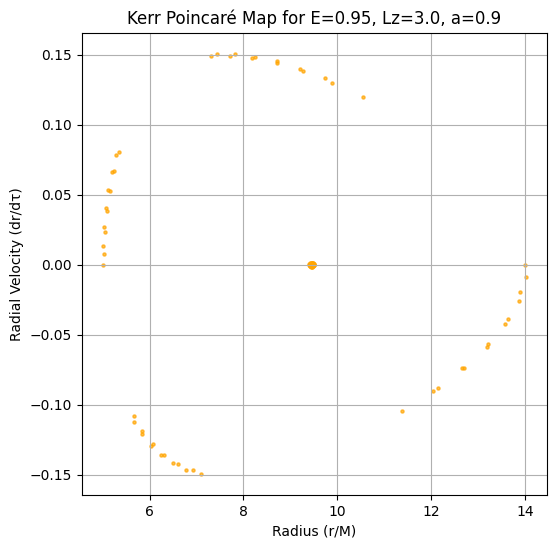

In [42]:
r_initial_kerr = np.linspace(5.0, 14.0, 3)
run_poincare_simulation_kerr(g_funcs_kerr, Gamma_funcs_kerr, E=E_val, Lz=Lz_val, a=A_BH, r0_values=r_initial_kerr)

The quantity
\begin{equation}
Q = (aE\sin\theta - L_z/\sin\theta)^2 + (r^2 + a^2\cos^2\theta)^2\left(\frac{d\theta}{d\tau}\right)^2 + \delta a^2\cos^2\theta
\end{equation}
is conserved for geodesic motion in the Kerr metric, where $\delta$ is a numerical constant yet to be determined. We can see that $\delta = -E^2$ which can be verified using CAS or a numerical approximation.


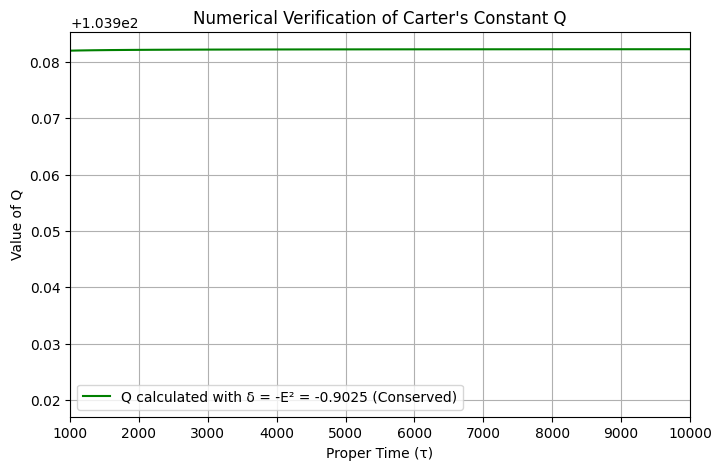

In [43]:
def calculate_carter_q(sol, E, Lz, a, delta):
    '''
    Calculates the value of the Carter constant Q along a trajectory.
    Args:
        sol: The solution object from the integrator.
        E: Conserved energy.
        Lz: Conserved z-component of angular momentum.
        a: Black hole spin parameter.
        delta: The numerical constant to be tested.
    Returns:
        An array of Q values along the trajectory.
    '''
    # Unpack solution variables
    r = sol.y[1]
    theta = sol.y[2]
    utheta = sol.y[6]

    # Calculate Sigma = r^2 + a^2*cos^2(theta)
    Sigma_sq = (r**2 + a**2 * np.cos(theta)**2)**2

    # Calculate each term of Q
    term1 = (a * E * np.sin(theta) - Lz / np.sin(theta))**2
    term2 = Sigma_sq * utheta**2
    term3 = delta * a**2 * np.cos(theta)**2

    Q_values = term1 + term2 + term3
    return Q_values

# Set up initial conditions for a generic 3D orbit
r0 = 7.0
theta0 = np.pi / 3 # Start away from the equatorial plane

g_tt0, g_tphi0, g_rr0, g_thth0, g_phphi0 = [
    f(r0, theta0) for f in [g_funcs_kerr[0,0], g_funcs_kerr[0,3], g_funcs_kerr[1,1], g_funcs_kerr[2,2], g_funcs_kerr[3,3]]
    ]

det = g_tt0 * g_phphi0 - g_tphi0**2
ut0 = (E_val * g_phphi0 + Lz_val * g_tphi0) / det
uphi0 = (-Lz_val * g_tt0 - E_val * g_tphi0) / det

# We can choose ur0 and solve for utheta0, or vice-versa
ur0 = 0.1

known_terms = g_tt0*ut0**2 + 2*g_tphi0*ut0*uphi0 + g_phphi0*uphi0**2 + g_rr0*ur0**2
utheta0_squared = (-1 - known_terms) / g_thth0
if utheta0_squared < 0:
    raise ValueError("Cannot start orbit, utheta would be imaginary.")
utheta0 = np.sqrt(utheta0_squared)

y0 = np.array([0., r0, theta0, 0., ut0, ur0, utheta0, uphi0])

# Integrate the orbit
solution = integrate_geodesic(y0, [0, 10000], Gamma_funcs_kerr)

# The "hypothesized correct" value
delta_correct = -E_val**2
Q_correct = calculate_carter_q(solution, E_val, Lz_val, A_BH, delta_correct)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(solution.t, Q_correct, 'g-', label=f'Q calculated with δ = -E² = {delta_correct:.4f} (Conserved)')

# Omit initial 1000 time
plt.title("Numerical Verification of Carter's Constant Q")
plt.xlabel("Proper Time (τ)")
plt.ylabel("Value of Q")
plt.grid(True)
plt.legend()
plt.xlim(1000, 10000)

plt.show()

To find what $Q$ becomes for the Schwarzschild metric, we set the spin parameter $a = 0$,
\begin{equation}
    Q = \frac{L_z^2}{\sin^2\theta} + r^4 \left(\frac{d\theta}{d\tau}\right)^2.
\end{equation}

In a spherically symmetric spacetime like Schwarzschild, the total angular momentum of an orbiting particle is conserved. The total angular momentum squared $L^2$ can be expressed in terms of its components in spherical coordinates. The momenta conjugate to $\theta$ and $\phi$ are
\begin{align}
    p_\theta &= g_{\theta\theta}\frac{d\theta}{d\tau} = -r^2\frac{d\theta}{d\tau}\\
    p_\phi &= g_{\phi\phi}\frac{d\phi}{d\tau} = -r^2\sin^2\theta\frac{d\phi}{d\tau}
\end{align}
We know that the conserved $z$-component of angular momentum is $L_z = - p_\phi$ and the formula for the squared magnitude of the total angular momentum in spherical coordinates is
\begin{equation}
    L^2 = p_\theta^2 + \frac{p_\phi^2}{\sin^2\theta} = r^4\left(\frac{d\theta}{d\tau}\right)^2 + \frac{L_z^2}{\sin^2\theta}
\end{equation}
This is exactly the expression we found for $Q$ in the $a \to 0$ limit.

In the limit of a non-spinning black hole $a = 0$, the constant $Q$ becomes the square of the magnitude of the total angular momentum vector $L^2$. The conservation of $Q$ for the Schwarzschild metric is simply the law of conservation of total angular momentum for motion in a spherically symmetric potential. For the Kerr metric, where the spacetime is only axisymmetric (not spherically symmetric) due to the black hole's spin, the total angular momentum is not conserved.